In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import pickle

def sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=None, th=0.2):
    ## this is number of neurons in total
    N_neurons= bkgd_log_proportions_array.shape[1]
    ## number of sequences from json file 
    n_sequences = config["num_sequence_types"]
    # the 18 neuron params for each neuron from the last iteration
    all_final_globals = neuron_response_df.iloc[-N_neurons:]
    # this cuts it down to just the first 6 params - i think this correspond sto the first param for each seq type? response probABILITY - ie the chance that a neuron spikes in a given latent seq 
    resp_prop = np.exp(all_final_globals.values[:, :n_sequences])#
    # this takes the next 6 params - which i think are the offset values
    offset = all_final_globals.values[-N_neurons:, n_sequences:2*n_sequences]
    ## finds the max response value - ie. which seq it fits to? 
    peak_response = np.amax(resp_prop, axis=1)
    # then threshold the reponse
    has_response = peak_response > np.quantile(peak_response, th)
    # I thin this is the sequence that the neuron has the max response for: ie. we are ordering them by max response 
    preferred_type = np.argmax(resp_prop, axis=1)
    if sequence_ordering is None:
        # order them by max reponse 
        ordered_preferred_type = preferred_type
    else:
        #order them differnetly 
        ordered_preferred_type = np.zeros(N_neurons)#
        # loop through each sequence
        for seq in range(n_sequences):
            # where does  max repsone = user defined seque
            seq_indices = np.where(preferred_type == sequence_ordering[seq])
            # change order to different seq
            ordered_preferred_type[seq_indices] = seq

    # reorder the offset params according to max respsone
    preferred_delay = offset[np.arange(N_neurons), preferred_type]
    Z = np.stack([has_response, ordered_preferred_type+1, preferred_delay], axis=1)
    indexes = np.lexsort((Z[:, 2], Z[:, 1], Z[:, 0]))
    return indexes,ordered_preferred_type

# Function to find corresponding number in another column
def find_corresponding(nums):
    return [df_dict[num] for num in nums]

def split_list(nums):
    sublists = []
    current_sublist = [nums[0]]
    current_element = nums[0]
    for i in range(1,len(nums)):
        if nums[i] == current_element:
            current_sublist.append(nums[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [nums[i]]
            current_element = nums[i]
    sublists.append(current_sublist)
    return sublists

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def load_H5_bodypart(tracking_path,video_type, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'task' in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)
  
def load_H5_ports(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'port' in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
    
    return(port1,port2,port3,port4,port5)

def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()
    plt.close()

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth



LOADING processed_spike_data


LOADING DLC TRACKING DATA
back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5
side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5
side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5
['head_centre' 'implant_centre' 'left_ear' 'right_ear' 'tail_base']
back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5
side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5
side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5
      A corresponding time span has been found. Time span set to [5400, 6000]


LOADING BEHAV DATA
done


Text(0.5, 1.0, 'timeframe = [0, 599]')

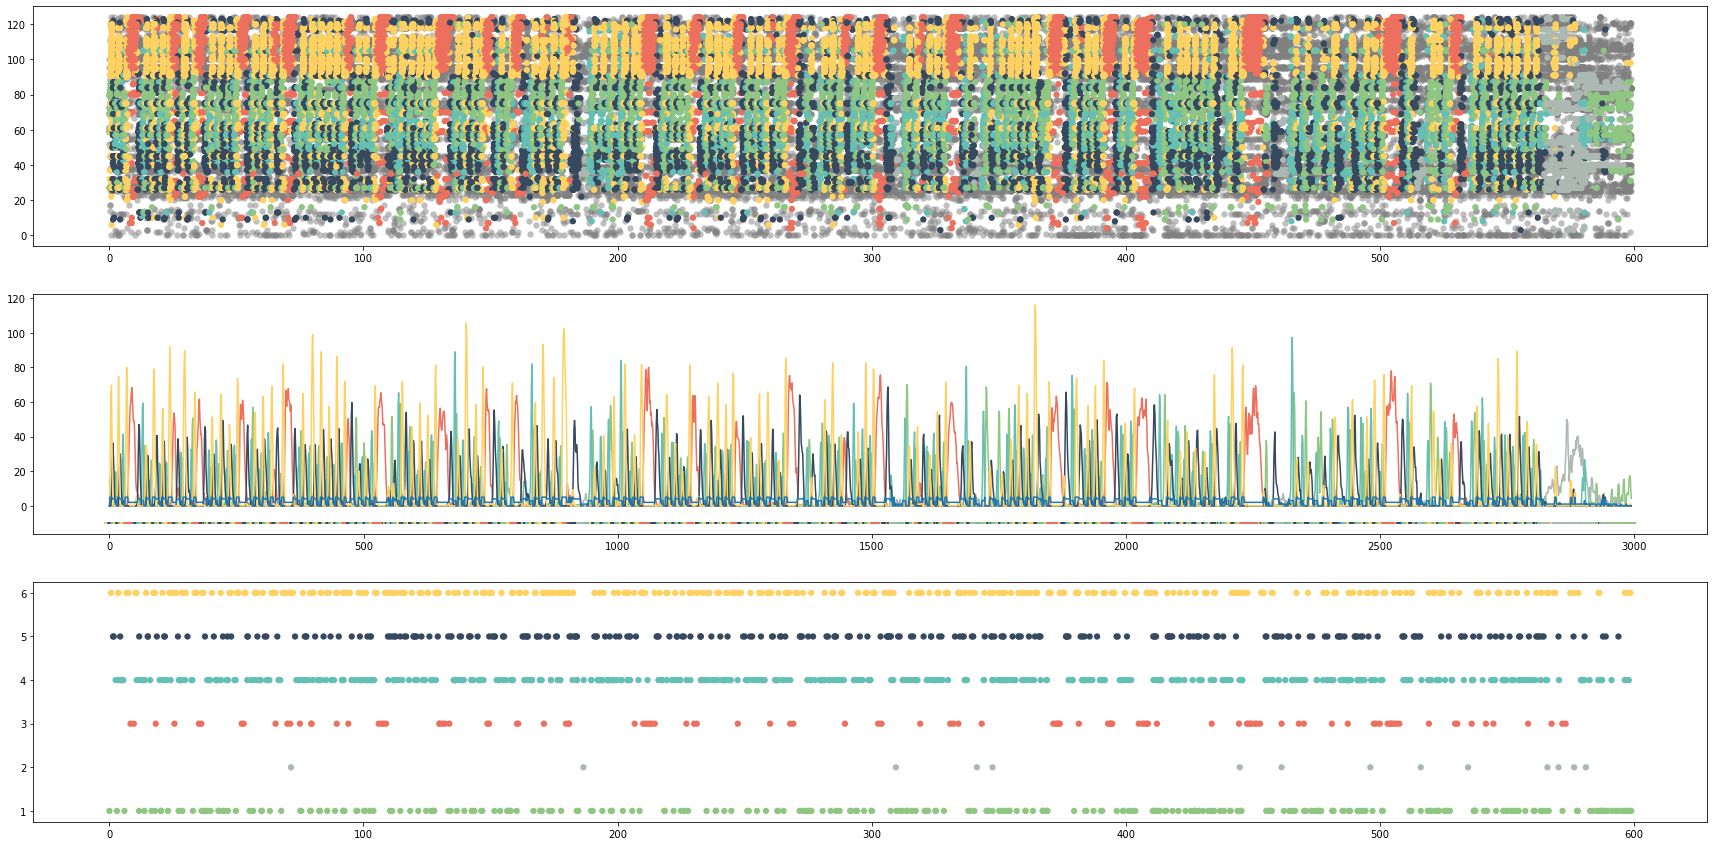

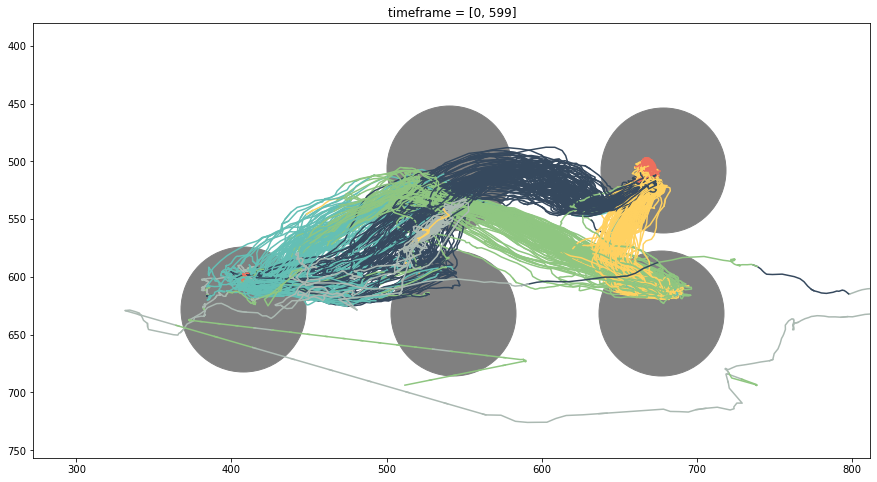

In [5]:
mouse_session_recording = '178_1_7'

## PATHS
PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"




region = 'striatum'



## set ppseq file
for file_ in os.listdir(PP_PATH):
    if mouse_session_recording in file_:
        file = file_

save_path = PP_PATH + file + r'\\analysis_output\reordered_recolored\fixed_standard_space\\'

## set dat_path:
for file_ in os.listdir(DAT_PATH):
    if mouse_session_recording.split('_')[0] in file_:
        if mouse_session_recording.split('_')[1] == file_[-1]:
            dat_path = os.path.join(DAT_PATH,file_)
for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
    if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
        dat_path = os.path.join(dat_path,recording)

# set tracking path
for file_ in os.listdir(dat_path + r"\video\tracking\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
# set video paths
for file_ in os.listdir(dat_path + r"\video\videos\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
            for vid_file in os.listdir(cam_path):
                if 'back' in vid_file and '.avi' in vid_file:
                    back_cam_avi_path = os.path.join(cam_path,vid_file)
                if 'side' in vid_file and '.avi' in vid_file:
                    side_cam_avi_path = os.path.join(cam_path,vid_file)


print('\n')
print("LOADING processed_spike_data")
### load in releavent things:

with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
    spikes_seq_type_adjusted = pickle.load(input_file)

import pickle
with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
    unmasked_spikes_df = pickle.load(input_file)

with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_order"), "rb") as input_file:
    neuron_order = pickle.load(input_file)

with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\colors"), "rb") as input_file:
    colors = pickle.load(input_file)

with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_index"), "rb") as input_file:
    neuron_index = pickle.load(input_file)

with open(PP_PATH + file + "\\analysis_output\\" + "latent_event_history_df_split.pickle", "rb") as input_file:
    latent_event_history_df_split = pickle.load(input_file)

ordered_preferred_type = np.load(PP_PATH + file + "\\analysis_output\\" + 'ordered_preferred_type.npy')

bkgd_log_proportions_array = pd.read_csv(PP_PATH + file + r"\bkgd_log_proportions_array.csv")


##### load deeplabcut tracking data
print('\n')
print("LOADING DLC TRACKING DATA")
back_head_centre = load_H5_bodypart(tracking_path,'back','head_centre')
back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports(tracking_path,'back')


## load in the timespan used for pppseq:
input_params_path = os.path.join(PP_PATH + file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
# Opening JSON file
f = open(input_params_path)
# returns JSON object as  a dictionary
input_config = json.load(f)
behav_time_interval_start = input_config['time_span'][0]
print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")


## LOAD behaviour data
print('\n')
print("LOADING BEHAV DATA")
try:
    behav_sync = pd.read_csv(dat_path + r'\behav_sync\2_task\Behav_Ephys_Camera_Sync.csv')
    transitions = pd.read_csv(dat_path + r'\behav_sync\2_task\Transition_data_sync.csv')
except:
    behav_sync = pd.read_csv(dat_path + r'\behav_sync\1_task\Behav_Ephys_Camera_Sync.csv')
    transitions = pd.read_csv(dat_path + r'\behav_sync\1_task\Transition_data_sync.csv')

behav_mask = (behav_sync.PokeIN_EphysTime>behav_time_interval_start[0])*(behav_sync.PokeIN_EphysTime<behav_time_interval_start[1])
poke_in_times = (behav_sync[behav_mask].PokeIN_EphysTime) - behav_time_interval_start[0]
ports = behav_sync[behav_mask].Port
print('done')



timeframe = [0,np.diff(behav_time_interval_start)[0]-1]

#mask
# spikemask
mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

1 ### plot ordered ppseq spikes as above:

# plot background in grey 
background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax1.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
# mask to remove background neurons from the color plot
background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

# Define the bin size (in this case, 0.2s)
bin_size = 0.2

seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
    seq_spike_occurance += [list(hist)]

strt_ = int(timeframe[0]/bin_size)
end_ = int(timeframe[1]/bin_size)

for i in range (1,len(seq_spike_occurance)):
#     ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])
    ax2.plot(convolve_movmean(seq_spike_occurance[i][strt_:end_],3), c = colors[i])


## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

ax2.plot(max_index[strt_:end_])

ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[np.array(max_index)+1][strt_:end_], s = 100)

### plot the ppseq latent:

# mask for the timespan
latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

# ignore anything that is below threshold * max amplitude
thr_ = 0
thresh_value = max(latent_event_history_df_split.amplitude) * thr_


amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)


# SaveFig('seq_identities.png',save_path)

fps = 60
if mouse_session_recording == '148_2_2':
    fps = 40

# behav_mask
mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])

# tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

# Find the difference between PokeIN_EphysTime and the start of the behavior interval
interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
# Find the offset between the first poke in time and the start of the timeframe
tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

# Get the first synced time for the camera in the interval 
interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
# Align the tracking start with the ephys by subtracting the offset
cam_start_time = interval_cam_times - tracking_offset

# Calculate the number of events based on the timeframe size and bin size
events = np.diff(timeframe)[0] /bin_size 
# Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
start_ts = [cam_start_time * fps ]
# Convert the bin size to timestamps - 60fps
bin_ts = bin_size * fps

# Create an empty list for end times
end_ts = []
# Loop through the number of events
for i in range(int(events)):
    # If it is not the first event, set the start time as the end time of the previous event
    if i > 0:
        start_ts += [end_ts[i-1]]
    # Add the current start time plus the bin size to the list of end times
    end_ts += [start_ts[i] + bin_ts] 



nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)
    for i in range(int(events)):
        ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)


    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    ax.invert_yaxis()

ax.set_title('timeframe = ' + str(timeframe))



Text(0.5, 1.0, 'timeframe = [550, 580]')

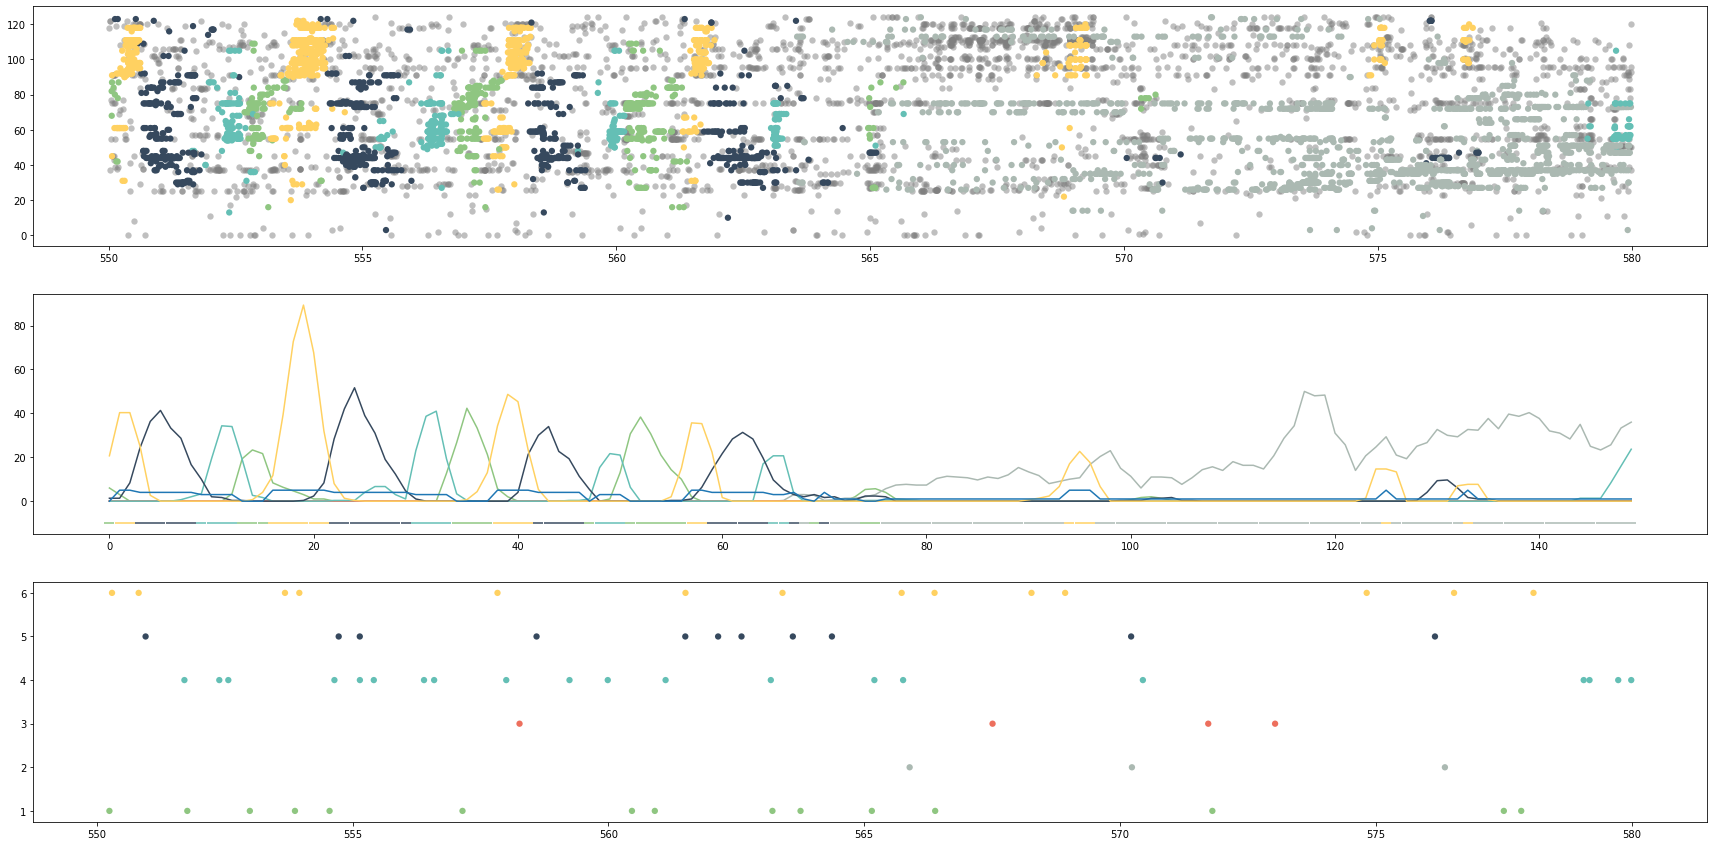

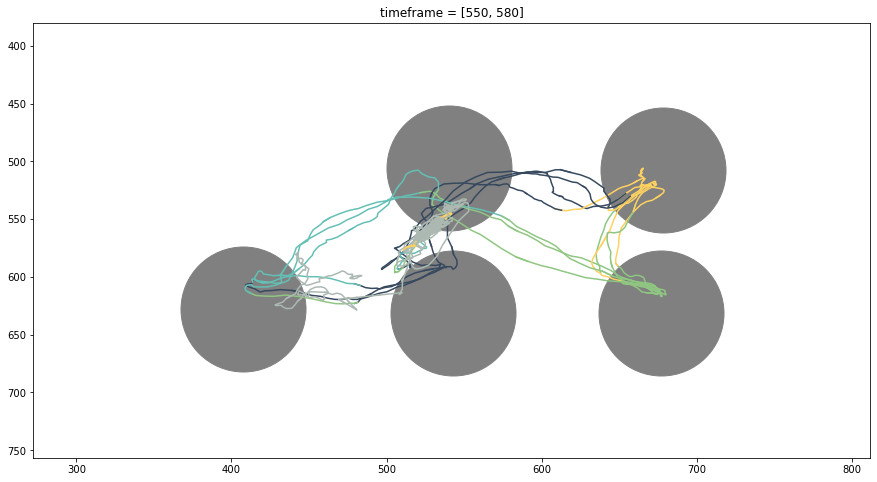

In [6]:

timeframe = [550,580]


#mask
# spikemask
mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

1 ### plot ordered ppseq spikes as above:

# plot background in grey 
background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
ax1.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
# mask to remove background neurons from the color plot
background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

# Define the bin size (in this case, 0.2s)
bin_size = 0.2

seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
    seq_spike_occurance += [list(hist)]

strt_ = int(timeframe[0]/bin_size)
end_ = int(timeframe[1]/bin_size)

for i in range (1,len(seq_spike_occurance)):
#     ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])
    ax2.plot(convolve_movmean(seq_spike_occurance[i][strt_:end_],3), c = colors[i])


## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

ax2.plot(max_index[strt_:end_])

ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[np.array(max_index)+1][strt_:end_], s = 100)

### plot the ppseq latent:

# mask for the timespan
latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

# ignore anything that is below threshold * max amplitude
thr_ = 0
thresh_value = max(latent_event_history_df_split.amplitude) * thr_


amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)


# SaveFig('seq_identities.png',save_path)

fps = 60
if mouse_session_recording == '148_2_2':
    fps = 40

# behav_mask
mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])

# tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

# Find the difference between PokeIN_EphysTime and the start of the behavior interval
interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
# Find the offset between the first poke in time and the start of the timeframe
tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

# Get the first synced time for the camera in the interval 
interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
# Align the tracking start with the ephys by subtracting the offset
cam_start_time = interval_cam_times - tracking_offset

# Calculate the number of events based on the timeframe size and bin size
events = np.diff(timeframe)[0] /bin_size 
# Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
start_ts = [cam_start_time * fps ]
# Convert the bin size to timestamps - 60fps
bin_ts = bin_size * fps

# Create an empty list for end times
end_ts = []
# Loop through the number of events
for i in range(int(events)):
    # If it is not the first event, set the start time as the end time of the previous event
    if i > 0:
        start_ts += [end_ts[i-1]]
    # Add the current start time plus the bin size to the list of end times
    end_ts += [start_ts[i] + bin_ts] 



nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)
    for i in range(int(events)):
        ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)


    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    ax.invert_yaxis()

ax.set_title('timeframe = ' + str(timeframe))



In [7]:
# set video paths
for file_ in os.listdir(dat_path + r"\video\videos\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
            for vid_file in os.listdir(cam_path):
                if 'back' in vid_file and '.avi' in vid_file:
                    back_cam_avi_path = os.path.join(cam_path,vid_file)
                if 'side' in vid_file and '.avi' in vid_file:
                    side_cam_avi_path = os.path.join(cam_path,vid_file)
                if 'Back' in vid_file and '.avi' in vid_file:
                    back_cam_avi_path = os.path.join(cam_path,vid_file)

from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.editor import ImageSequenceClip

def add_label_to_frame(frame, label, color):
    # Convert the frame to a PIL image
    img = Image.fromarray(frame)
    # Create a drawing context
    draw = ImageDraw.Draw(img)
    # Define the font and size
    font = ImageFont.truetype("arial.ttf", 80)
    # Draw the label on the image
    draw.text((10, 10), label, font=font, fill=color)
    # Convert the image back to a numpy array
    return np.array(img)


def add_tracking_line_to_frame(frame, x, y, color, prev_colour,prev_point):
    # Convert the frame to a PIL image
    img = Image.fromarray(frame)
    # Create a drawing context
    draw = ImageDraw.Draw(img)
    # Draw the line on the image
    draw.text([x, y], 'o', fill=color, font=ImageFont.truetype("arial.ttf", 40))
    # Draw the previous point on the image, if it exists
    if len(prev_point) >0:
        if len(prev_point) >= 40:
            start_ = -20
        else:
            start_ = 0
        for index,point in enumerate(prev_point[start_::]):
            color = prev_colour[start_+index]
            draw.text([point[0],point[1]], 'o', fill=color, font=ImageFont.truetype("arial.ttf", 40))
    # Convert the image back to a numpy array
    return np.array(img)

## work out the start and end frames 
## work out the text an colour labels for each frame. 
tot_frames = (end_ts[-1]/60 - start_ts[0]/60) * 60
frames_per_bin = bin_size/(1/60)

frame_label_colors= []
for seq_label_ in np.array(colors)[np.array(max_index)+1][strt_:end_]:
    frame_label_colors += int(frames_per_bin) * [seq_label_]
    
frame_labels= []
for seq_label_ in np.array(colors)[np.array(max_index)+1][strt_:end_]:
    if seq_label_ == '#ABB9B2':
        frame_labels += int(frames_per_bin) *['grooming']
    elif seq_label_ == '#36495E':
        frame_labels += int(frames_per_bin) *['sequence 1']
    elif seq_label_ == '#64BFB5':
        frame_labels += int(frames_per_bin) *['sequence 2']
    elif seq_label_ == '#8FC681':
        frame_labels += int(frames_per_bin) *['sequence 3']
    elif seq_label_ == '#FFD161':
        frame_labels += int(frames_per_bin) *['sequence 4']
    elif seq_label_ == '#ED6F5D':
        frame_labels += int(frames_per_bin) *['sequence 5']
    
# work out head centre position
x_coords = back_head_centre['interped_x'].values[int(start_ts[0]):int(end_ts[-1])]
y_coords = back_head_centre['interped_y'].values[int(start_ts[0]):int(end_ts[-1])]

# Open the video file
clip = VideoFileClip(back_cam_avi_path)

# Extract clip
clip = clip.subclip(start_ts[0]/60, end_ts[-1]/60)

# Create a list to store the labeled frames
labeled_frames = []


# Create a variable to store the previous plotted point
prev_points = []
prev_colour = []

# Iterate through the frames of the clip
for i, frame in enumerate(clip.iter_frames()):
    # Add the label to the frame
    labeled_frame = add_label_to_frame(frame, frame_labels[i], frame_label_colors[i])
    #try adding a line to the head
    if i < tot_frames-1:
        # Plot the point on the current frame using the previous plotted point
        labeled_frame = add_tracking_line_to_frame(labeled_frame,x_coords[i],y_coords[i],frame_label_colors[i],prev_colour,prev_points)
        # Update the previous plotted point
        prev_points += [(x_coords[i],y_coords[i])]
        prev_colour += [frame_label_colors[i]]
    # Add the labeled frame to the list   
    labeled_frames.append(labeled_frame)
    

# Create a new clip with the labeled frames
labeled_clip = ImageSequenceClip(labeled_frames, fps=clip.fps)

# Save the labeled clip to a new video file
labeled_clip.write_videofile(save_path + 'new_video_scoring_extra_seqs.mp4')

t:   0%|                                                                            | 0/1800 [00:00<?, ?it/s, now=None]

Moviepy - Building video Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\178_1_7_run_2701023_1720\\analysis_output\reordered_recolored\fixed_standard_space\\new_video_scoring_extra_seqs.mp4.
Moviepy - Writing video Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\178_1_7_run_2701023_1720\\analysis_output\reordered_recolored\fixed_standard_space\\new_video_scoring_extra_seqs.mp4



Moviepy - Done !
Moviepy - video ready Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\178_1_7_run_2701023_1720\\analysis_output\reordered_recolored\fixed_standard_space\\new_video_scoring_extra_seqs.mp4
